# Introduction to the Table Access Protocol (TAP) Service

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
Contact authors: Leanne Guy, Melissa Graham <br>
Last verified to run: 2024-12-17 <br>
LSST Science Pipelines version: Weekly 2024_50 <br>
Container Size: medium <br>
Targeted learning level: beginner <br>

**Description:** Explore the DP0.2 catalogs with the TAP service.

**Skills:** Use the TAP service. Make simple ADQL queries. Visualize retrieved datasets.

**LSST Data Products:** Catalog schema. Object table.

**Packages:** lsst.rsp

**Credit:**
Originally developed by Leanne Guy in the context of the Rubin DP0.1.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook provides a beginner-level demonstration of how to use
Astronomy Data Query Language (ADQL) to access DP0.2 catalog data via
Rubin's Table Access Protocol (TAP) service.

The [documentation for Data Preview 0.2](https://dp0-2.lsst.io/) includes definitions
of the data products, descriptions of catalog contents, and ADQL recipes.
The RSP's Portal Aspect, with its graphical user interface, is also
recommended for exploring the available catalogs and for testing queries.

### 1.1. TAP basics

TAP provides standardized access to catalog data for discovery, search, and retrieval.
Full [documentation for TAP](http://www.ivoa.net/documents/TAP) is provided by the
International Virtual Observatory Alliance (IVOA).

TAP Glossary
* schema - Database terminology for the abstract design that represents the storage of data in a database.
* `tap_schema` - The set of tables that describe the data tables and their columns.
* table collection - A collection of tables. E.g., `dp02_dc2_catalogs`.
* table - A collection of related data held in a table format in a database. E.g., `dp02_dc2_catalogs.Object`.
* query - A string formatted in ADQL that selects data from a table, with contraints if desired. 
* results - The output of the TAP service's search method when a query is passed.

### 1.2. ADQL basics

The [documentation for ADQL](http://www.ivoa.net/documents/latest/ADQL.html)
includes more information about syntax, keywords, operators, functions, and so on.
ADQL is similar to SQL (Structured Query Langage).

A typical ADQL statement has at least three components:

`SELECT <columns> FROM <catalog> WHERE <constraints>`,

where
 * `<columns>` is a comma-separated list of the columns to return,
 * `<catalog>` is the name of the catalog to retreive data from, and
 * `<constraints>` imposes a restriction that only rows with column values that meet the constraints are returned.

For example, say there is a catalog called "mysurveydata" with 5 columns, "col1", "col2", and so on.
The ADQL statement:

`SELECT col3, col4, col5 FROM mysurveydata WHERE col1 > 0.5 AND col5 < 10`

would 
return a table that has three columns, and as many rows as meet both of the restrictions in the `WHERE` statement.

As the DP0.2 catalogs are _very_ large, the ADQL statement to return an entire
table **should not** be used (`SELECT * FROM mysurveydata`).


### 1.3. What is not covered in this tutorial?

The following intermediate-level TAP functionalities for retrieving catalog data are _not_ demonstrated in this tutorial,
but are covered in other tutorials.

See DP0.2 tutorial notebook 02b for:
 * table joins
 * renaming columns
 * applying mathematical functions
 * converting fluxes to magnitudes
 * querying and visualizing large data sets

See DP0.2 tutorial notebook 02c for ObsTAP queries for images (metadata and pixel data).

### 1.4. Recommendations for TAP queries

The following recommendations are all demonstrated in Section 3.

#### 1.4.1. Use asynchronous queries
In Section 2, synchronous queries are used with `results = service.search(query)`. 
This is OK for querying schema or small amounts of data, but when more data is being
retrieved it is recommended to use asynchronous jobs with `job = service.submit_job(query)`
as demonstrated in Section 3.

#### 1.4.2. Include coordinate constraints
When possible include coordinate constraints (e.g., use a cone search).
The TAP-accessible tables are sharded by coordinate (RA, Dec).
ADQL query statements that include constraints by coordinate do not require a
whole-catalog search, and are typically faster (and can be much faster) than
ADQL query statements which only include constraints for other columns.

#### 1.4.3. Constrain detect_isPrimary = True
As a default, it is recommended to include a constraint of `detect_isPrimary = True` in queries for the 
`Object`, `Source`, and `ForcedSource` catalogs.
This parameter is `True` if a source has no children, is in the inner region of a coadd patch, 
is in the inner region of a coadd tract, and is not detected in a pseudo-filter.
Including this constraint will remove any duplicates (i.e., will not include both a parent and its deblended children).
Only remove this constraint in situations where duplicates are desired.

#### 1.4.4. If limiting rows, use TOP
Use of `TOP` is preferred to `maxrec` because most
TAP services map `maxrec` to `SELECT TOP` on the back end anyways.
Using `TOP` ensures that queries are copy-pasteable between interfaces
(e.g., into the Portal Aspect).

#### 1.4.5. If sorting, take care with ORDER BY
Combined use of TOP and ORDER BY in ADQL queries can be dangerous: it may take an unexpectedly long
time because the database is trying to first sort, and *then* extract the top N elements.
It is best to only combine TOP and ORDER BY if the query's WHERE statements significantly cut
down the number of objects that would need to be sorted.

### 1.5. Import packages

Import general python packages
([pandas](https://pandas.pydata.org/docs/user_guide/index.html),
[numpy](https://numpy.org/doc/stable/index.html), and
[matplotlib](https://matplotlib.org/)),
two classes from [astropy](https://www.astropy.org/),
and the Rubin Science Platform (RST) TAP service.

In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.visualization.wcsaxes import SphericalCircle
from lsst.rsp import get_tap_service, retrieve_query

### 1.6. Define functions and parameters

Get an instance of the TAP service, and assert that it exists.

In [ ]:
service = get_tap_service("tap")
assert service is not None

Set the maximum number of rows to display from pandas.

In [ ]:
pandas.set_option('display.max_rows', 20)

## 2. Explore the TAP schema 

This section will use ADQL queries of increasing complexity to both explore 
the available catalog data and to demonstrate how to use the TAP service and ADQL.

### 2.1. Synchronous queries

This section uses "synchronous" TAP queries.
This means that the query is run and the results are retrieved at the same time.
No other cells can be run while this is happening.

Since the queries in this section are very simple, and are only retrieving schemas (not data),
they are very quick and synchronous queries work fine.
However, when data is retrieved from catalogs, asynchronous queries should be used (Section 3).

### 2.2. List all catalogs (schema)

Create an ADQL query that selects all columns (*) from the `tap_schema`.
The results of the query will be a list of available schemas (in other words, the available catalogs).

Store it in a string named `query`.

In [ ]:
query = 'SELECT * FROM tap_schema.schemas'

Execute the query by passing `query` to the TAP service's search method,
and store the output in `results`.

In [ ]:
results = service.search(query)

Print the type of `results`.

In [ ]:
print(type(results))

`TAPResults` is a python class from the
[PyVO Data Access](https://pyvo.readthedocs.io/en/latest/dal/index.html) package.
The [documentation for TAPResults](https://pyvo.readthedocs.io/en/latest/api/pyvo.dal.TAPResults.html)
has more information about the class and its methods.

Typically, for convenience it is recommended to convert the results into an
[Astropy table](https://docs.astropy.org/en/stable/table/).

Rerun the query, but store the results as an astropy table with the `to_table()` method.

In [ ]:
results_table = service.search(query).to_table()

Print the type of `results` and see that it is an `astropy` table.

In [ ]:
print(type(results_table))

Display the table.

In [ ]:
results_table

The table above shows that the DP0.2 data `schema_name` is `dp02_dc2_catalogs`.

"DC2" stands for "Data Challenge 2" and it was the name of the effort by
the Dark Energy Science Collaboration to create the simulated data
([The DESC DC2 Simulated Sky Survey](https://arxiv.org/abs/2010.05926)).

Although the description says "Data Preview 0.2 contains the image and catalog products...",
the `dp02_dc2_catalogs` contains only catalog data and image data for DP0.2 is 
stored in the `ObsCore`, with `schema_name` = `ivoa`. 
Accessing image data via the TAP service is covered in another tutorial.

The above table is quite short, and it is obvious from looking at it 
that the table collection for DP0.2 is `dp02_dc2_catalogs`.
However, there may be times in the future when there are many more
schemas available.
The following demonstrates a way to search for catalogs by name.

Use a `for` loop to look for the presence of `dp02` in the
`schema_name` column for every row of the results table,
and write the name when there is a match.

In [ ]:
for name in results_table['schema_name']:
    if name.find('dp02') > -1:
        print(name)

Clean up by deleting the query and its results.

In [ ]:
del query, results, results_table

### 2.3. List all tables in the DP0.2 catalog

Create a query that selects all columns from `tap_schema.tables`
for the `dp02_dc2_catalogs` schema.
Add an ORDER BY statement to return the results sorted by `table_index`.

This query will return the names of all tables that are available in the `dp02_dc2_catalogs`.

In [ ]:
query = "SELECT * FROM tap_schema.tables " \
        "WHERE tap_schema.tables.schema_name = 'dp02_dc2_catalogs'" \
        "ORDER BY table_index ASC"

Use a synchronous query and return the results as an astropy table.

In [ ]:
results = service.search(query).to_table()

Display the results to see the tables in the DP0.2 schema.

In [ ]:
results

Clean up.

In [ ]:
del query, results

### 2.4. List all columns in the Object table

For the example, use the first table: the `Object` table (see Section 3).

The following query selects four colums from the `tap_schema.columns` table,
column names, data types, descriptions, and units,
only for the `Object` table.

In [ ]:
query = "SELECT column_name, datatype, description, unit " \
        "FROM tap_schema.columns " \
        "WHERE table_name = 'dp02_dc2_catalogs.Object'"

Run the synchronous query and store results in an astropy table.

In [ ]:
results = service.search(query).to_table()

Display the results.

In [ ]:
results

Above, notice that the table is very long (991 rows) and the display has been truncated (the '...' represents skipped rows).
There are too many columns to read through.

Use a `for` loop to look for the presence of `coord` in the
`column_name` column for every row of the results table,
and write the name when there is a match.

In [ ]:
search_string = 'coord'
for cname in results['column_name']:
    if cname.find(search_string) > -1:
        print(cname)

Repeat the above exercise, but for all columns that are related to the *g*-band PSF (point spread function) flux measurements.
This flux measurement is appropriate to use for point-like objects, like stars.

Notice that there is a flux, and error, and several flag values.
Flags indicate various warnings, e.g., if the source was close to the edge of the detector and thus might be missing some flux.

In [ ]:
search_string = 'g_psfFlux'
for cname in results['column_name']:
    if cname.find(search_string) > -1:
        print(cname)

The `datatype` column has a limited set of values.
Print the unique data types.

In [ ]:
print(np.unique(results['datatype']))

The `units` column also has a limited set of values.
Print the unique set of units used in the `Object` table.

In [ ]:
print(np.unique(results['unit']))

Clean up.

In [ ]:
del query, results

## 3. Query the DP0.2 Object table

The `Object` table contains measurements for all objects detected
in the deep coadd (stacked) images.
It includes objects detected with a signal-to-noise ratio of at least five in at least one filter.
Detections are deblended, e.g., overlapping galaxies (blended sources in the image), are split into
individual objects (referred to as 'parent' and 'child' objects).
The measurements of these objects, such as shapes, sizes, and fluxes, are made in all filters.

The Object catalog (`dp02_dc2_catalogs.Object`) contains sources detected in the coadded images (also called stacked or combined images).

### 3.1. Asynchronous queries

This section uses "asynchronous" TAP queries.
This means that the query is submitted as a job to the TAP service,
and it can run in the background until it completes.
The results can then be retrieved right away, or at a later time.
Other cells can be run while this is happening.

Since the queries in this section are more complex, and retrieving rows of data (not just schema),
asynchronous queries are used.

### 3.2. Cone search

A cone search means a catalog query that returns all objects within a given radius of a sky coordinate.
Since a given angular diameter corresponds to a larger physical diameter at larger distances,
the volume queried is a cone, not a cylinder.

In ADQL, a cone search is executed with `WHERE CONTAINS(POINT(), CIRCLE()) = 1`.
 * `POINT()` passes the catalog's columns for sky coordinates.
 * `CIRCLE()` defines the center and radius of the search circle.
 * `CONTAINS() = 1` constrains the query to only return rows for which the statement "this circle contains this point" is "True" (=1).

In Section 2.4, the columns for sky coordinate in the `Object` catalog
were shown to be `coord_ra` and `coord_dec`, with units of degrees. 
The approximate center of the DP0.2 area is RA, Dec = 62.0, -37.0 (decimal degrees).
A conservative radius that ensures a quick query with a limited number of rows returned in 0.01 degrees (36 arcsec).

The following query would return the `coord_ra` and `coord_dec` columns for all rows of the `Object` table
which are within 0.05 degrees of RA, Dec = 62.0, -37.0, and for which the `detect_isPrimary` column is "True" (as recommended above).
The `'ICRS'` stands for "International Celestial Reference System", the reference frame for the coordinates.

```
SELECT coord_ra, coord_dec FROM dp02_dc2_catalogs.Object 
WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', 62, -37, 0.05")) = 1 
AND detect_isPrimary = 1
```

Define the center coordinates and the radius.
TAP queries are created as strings, so define `str_center_coords` and `str_radius` as strings
which can be inserted into the query string.

In [ ]:
center_ra = 62
center_dec = -37
radius = 0.01

str_center_coords = str(center_ra) + ", " + str(center_dec)
str_radius = str(radius)

Create the query string, and print it.

In [ ]:
query = "SELECT coord_ra, coord_dec "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 1"
print(query)

Submit the `query` as an asynchronous job to the TAP service.

In [ ]:
job = service.submit_job(query)
print('Job URL is', job.url)
print('Job phase is', job.phase)

Run the job.

In [ ]:
job.run()

Wait for the job status to be either "COMPLETED" or "ERROR".

This is not mandatory, but is recommended; if it is not run, there will be no other
automatic notification that the job is no longer running.
However, note that if this cell is executed then no other cells can be executed while the job runs in the background.

In [ ]:
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

**Optional:** If the status returned was "ERROR", uncomment and execute this cell to print the error messages.

In [ ]:
# job.raise_if_error()

If the status returned was "COMPLETED", execute this cell to retrieve the query results as an `astropy` table
and print the length of the table.

In [ ]:
results = job.fetch_result().to_table()
print(len(results))

**Optional:** Uncomment and execute to display the table contents.

In [ ]:
# results

Plot the coordinates, right ascension (RA) vs. declination (Dec).

Use the `astropy` class `SphericalCircle` to shade the query region.
This class takes into account the "cos-dec" factor
(for points off the celestial equator, i.e., at non-zero declination, the real distance
in the right ascension axis is smaller by a factor of the cosine of the declination).

In [ ]:
fig = plt.figure(figsize=(4, 4))

region = SphericalCircle((center_ra * u.deg, center_dec * u.deg),
                         radius * u.deg, alpha=0.2, color='blue')
plt.gca().add_patch(region)

plt.plot(results['coord_ra'], results['coord_dec'],
         'o', alpha=0.5, color='black', mew=0)

plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

Figure 1: The Right Ascension (RA) versus Declination (Dec) coordinates for Objects retrieved by the query (black dots) within the query region (blue circle).

Clean up (and save memory) by deleting the job and its results.

In [ ]:
job.delete()
del query, results

### 3.3. Limit rows returned with TOP

For debugging and testing queries, it can be useful to only retrieve a subset of the rows
which meet the query constraints, because this is faster.

Alter the query used above to use `TOP` to return only `N` rows.

In [ ]:
N = 20

In [ ]:
query = "SELECT TOP " + str(N) + " coord_ra, coord_dec "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 1"
print(query)

Run the job asynchronously and wait until it is finished.

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

In [ ]:
results = job.fetch_result().to_table()
print(len(results))

In [ ]:
fig = plt.figure(figsize=(4, 4))
region = SphericalCircle((center_ra * u.deg, center_dec * u.deg),
                         radius * u.deg, alpha=0.2, color='blue')
plt.gca().add_patch(region)
plt.plot(results['coord_ra'], results['coord_dec'],
         'o', alpha=0.5, color='black', mew=0)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

Figure 2: The Right Ascension (RA) versus Declination (Dec) coordinates for only the top 20 Objects retrieved by the query (black dots) within the query region (blue circle). All of the black dots are in the lower half of the blue circle.


Clean up.

In [ ]:
job.delete()
del query, results

### 3.4. Use of maxrec instead of TOP

TAP queries run in the Notebook Aspect of the RSP can also use the `maxrec` keyword for the TAP service.
Use of `TOP` is preferred, as described in Section 1.4.4, but they work the same way from a Jupyter Notebook.

Use the same query as above, but without `TOP`.

In [ ]:
query = "SELECT coord_ra, coord_dec "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 1"
print(query)

Include `maxrec` as a keyword when submitting the query to the TAP service. Run the job.

In [ ]:
job = service.submit_job(query, maxrec=N)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Retrieve the job results.

> **Warning:** Use of `maxrec` might return a `DALOverflowWarning` when the results are retrieved. This warns the user that partial results have been returned. In this case, it is ok to ignore this warning, because the query's intent was to return partial results by using `maxrec`.

In [ ]:
results = job.fetch_result().to_table()
print(len(results))

Plot the results.

In [ ]:
fig = plt.figure(figsize=(4, 4))
region = SphericalCircle((center_ra * u.deg, center_dec * u.deg),
                         radius * u.deg, alpha=0.2, color='blue')
plt.gca().add_patch(region)
plt.plot(results['coord_ra'], results['coord_dec'],
         'o', alpha=0.5, color='black', mew=0)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

Figure 3: Identical to Figure 2.

Clean up.

In [ ]:
job.delete()
del query, results

### 3.5. Sort results with ORDER BY

As described in Section 1.4.5, **use `ORDER BY` and `TOP` together with caution**.

The TAP service first applies `WHERE` constraints, then `ORDER BY`, and then `TOP`.
If the query is not well constrained, i.e., if thousands or more objects meet the `WHERE`
constraints, then they all must first be sorted before the top number are returned. 
This is a waste of time and compute resources.

Create the query. Add an `ORDER BY` statement to the TAP query to return the `TOP` N objects
sorted by `coord_ra`, in ascending (`ASC`) order.

In [ ]:
query = "SELECT TOP " + str(N) + " coord_ra, coord_dec "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 1 "\
        "ORDER BY coord_ra ASC"
print(query)

Run the job.

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Retrieve the results.

In [ ]:
results = job.fetch_result().to_table()
print(len(results))

Plot the results.

In [ ]:
fig = plt.figure(figsize=(4, 4))
region = SphericalCircle((center_ra * u.deg, center_dec * u.deg),
                         radius * u.deg, alpha=0.2, color='blue')
plt.gca().add_patch(region)
plt.plot(results['coord_ra'], results['coord_dec'],
         'o', alpha=0.5, color='black', mew=0)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

Figure 4: Similar to Figure 2, except the top 20 Objects returned (black dots) are all on the left-most edge of the blue circle, because they have the lowest RA values,
and the query results were sorted by RA in ascending order before the top 20 were selected.

Clean up.

In [ ]:
job.delete()
del query, results

### 3.6. Sort results with pandas

The `pandas` package provides high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
TAP query results can be converted to `pandas` dataframes, and then `pandas` functionality (such as sorting) can be applied to the dataframe.

Use the same query as above for a small, unsorted set of Objects.

In [ ]:
query = "SELECT coord_ra, coord_dec "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 1"
print(query)

Run the job.

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Retrieve the results, and use the `to_pandas()` method to convert `results` to a `pandas` dataframe.

In [ ]:
results = job.fetch_result().to_table().to_pandas()
print(len(results))

Print the type of `results` and see that it is a `pandas` dataframe.

In [ ]:
print(type(results))

Display the results.

In [ ]:
results

In general, the order of results from TAP queries cannot be assumed to be the same every time,
and they will not necessarily be sorted unless `ORDER BY` has been used in the query statement.

Use the `pandas` method `sort_values` to sort the dataframe by `coord_ra`, save it as a new
dataframe named `sorted_results`, and display the new sorted dataframe.

In [ ]:
sorted_results = results.sort_values('coord_ra')

In [ ]:
sorted_results

Notice that the index values did not update, and are not in the order of the sorted dataframe.

To reset the index, use the `pandas` method `set_index` to reset the index of the `sorted_results` dataframe.

In [ ]:
sorted_results.set_index(np.array(range(len(sorted_results))), inplace=True)

In [ ]:
sorted_results

Clean up.

In [ ]:
job.delete()
del query, results, sorted_results

## 4. Retrieve query results with job URL

Job results are generally available from previously run queries,
and can be retrieved if the URL of the job is known _and_ if the job
has not been deleted.

Do not use `job.delete()` if the results will be retrieved later!

First, execute the same query as used above.

In [ ]:
query = "SELECT coord_ra, coord_dec "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 1"
print(query)

job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Instead of using `job.fetch_result()`, store the `job.url` as `my_job_url` and print it.

In [ ]:
my_job_url = str(job.url)
print(my_job_url)

This URL can be used to retrieve the query results.

The URL could be shared with another user of the Rubin TAP service, and they could retrieve the same results.

Retrieve the job by passing `my_job_url` to `retrieve_query`, then retrieve the results with `fetch_result()`.

In [ ]:
retrieved_job = retrieve_query(my_job_url)
retrieved_results = retrieved_job.fetch_result().to_table().to_pandas()

In [ ]:
retrieved_results

Clean up.

In [ ]:
job.delete()
del query, retrieved_results

### 4.1. Retrieve results from a Portal query

It is also possible to retrieve the results of queries executed in the Portal Aspect of the Rubin Science Platform.

#### 4.1.1. Run an ADQL query in the Portal

In a new browser tab, go to <a href="https://data.lsst.cloud/">data.lsst.cloud</a> and enter the Portal Aspect.

Click on the tab "DP0.2 Catalogs" at the top of the screen.

Click "Edit ADQL" at upper right.

Copy-paste the following query into the ADQL box as shown in the screenshot below.

```
SELECT coord_ra, coord_dec FROM dp02_dc2_catalogs.Object
WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', 62, -37, 0.01)) = 1
AND detect_isPrimary = 1
```


<div style="max-width:700px;margin-right: auto; margin-right: 0;">
    
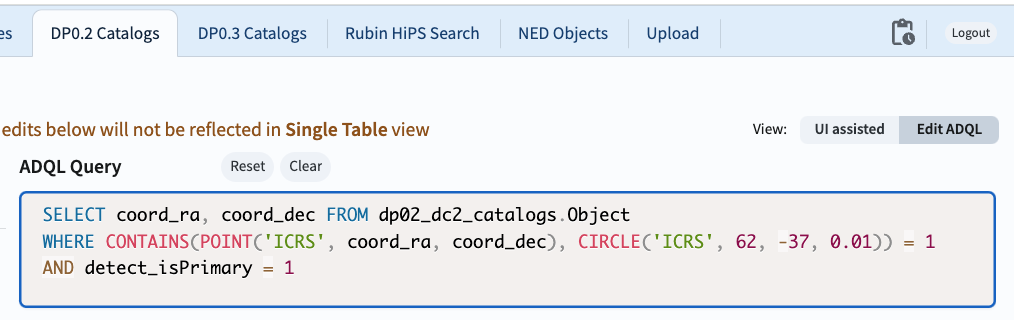

</div>


Figure 5: A screenshot of the Portal's ADQL interface, with the query statement copied in.

Click "Search" in the lower left corner of the Portal.

#### 4.1.2. Get the job URL from the Portal

The default results view will appear as in the screenshot below.



<div style="max-width:700px;margin-right: auto; margin-right: 0;">

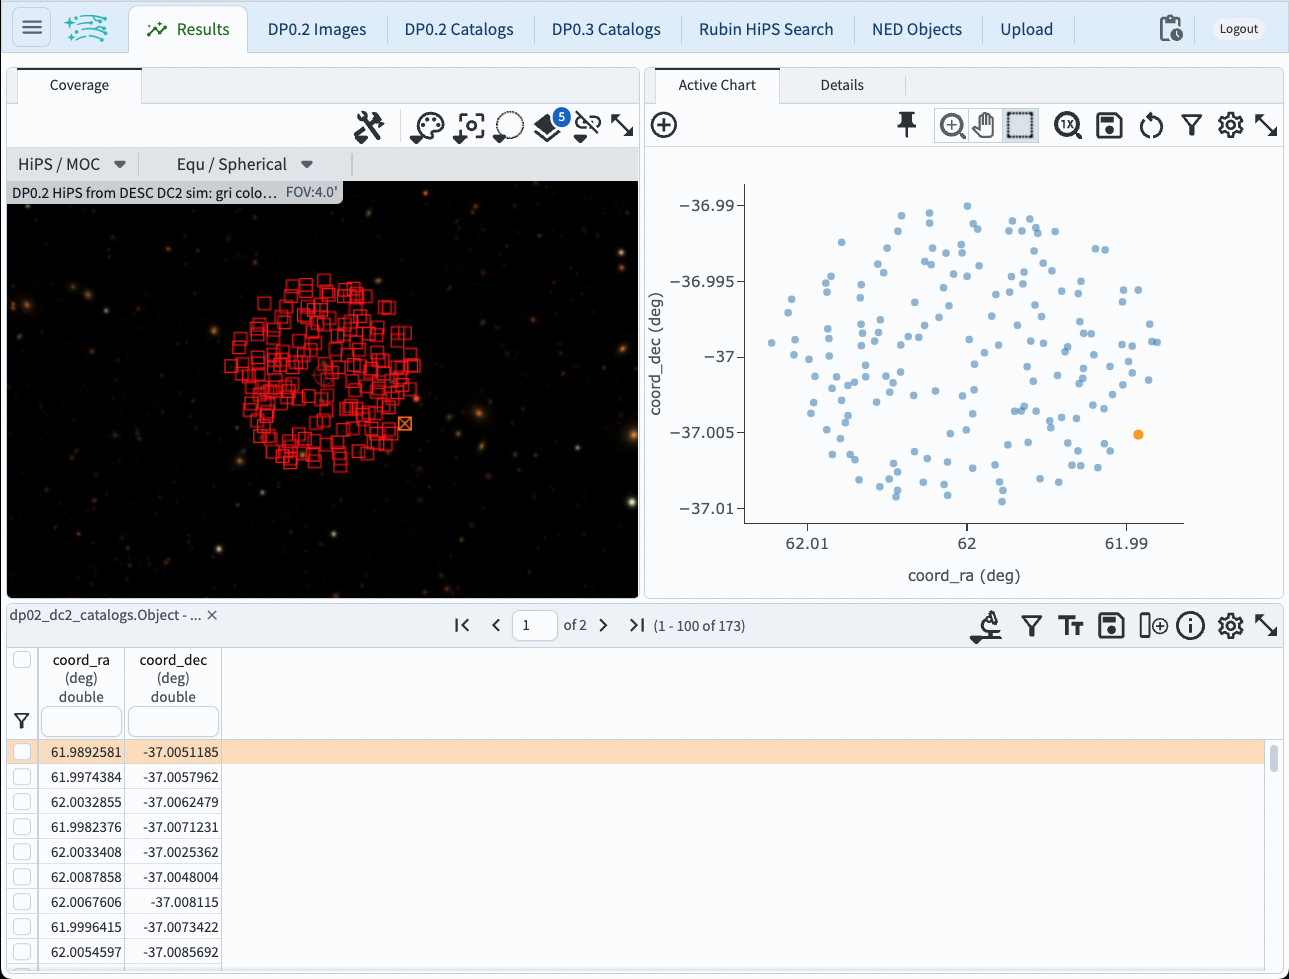

</div>

Figure 6: A screenshot of the Portal's results view for the ADQL query in Figure 5.

The search results have been automatically saved and assigned a URL.

Click on the "Info" button (the letter i in a circle),
which is in the upper right-hand corner of the table (bottom of the screen).

The pop-up window contains the URL (the Job Link).


<div style="max-width:500px;margin-right: auto; margin-right: 0;">

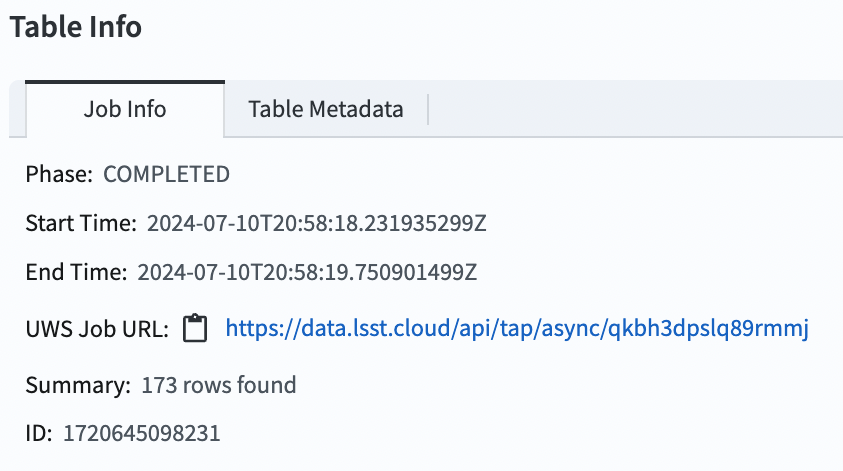

</div>

Figure 7: A screenshot of the table information, including the Job URL.

#### 4.1.3. Retrieve the results

Follow the instructions above to create a new URL.

> **Warning:** Using the job URL in the screenshot above will not work, it has expired.

Copy the newly created URL into the empty quotes below to define `my_portal_url`.

Uncomment and execute the following cells to obtain the results of 
the Portal query here in the Notebook.

In [ ]:
# my_portal_url = ''
# retrieved_job = retrieve_query(my_portal_url)
# retrieved_results = retrieved_job.fetch_result().to_table().to_pandas()

In [ ]:
# retrieved_results

Delete the retrieved job and clean up.

In [ ]:
# retrieved_job.delete()
# del retrieved_results